In [2]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from datetime import datetime
import networkx as nx
import statsmodels.api as sm

sys.path.insert(0, str(Path.cwd().parent))

from src.behavior_import.import_data import *
from src.behavior_import.extract_trials import *
from src.behavior_import.filter_trials_by_subject import *
from src.behavior_analysis.get_good_reversal_info import *
from src.behavior_analysis.get_choice_probs_around_good_reversals import *
from src.behavior_analysis.split_early_late_good_reversals import *
from src.behavior_analysis.get_first_leave_after_good_reversals import *
from src.behavior_analysis.get_rank_counts_by_good_reversal import *
from src.behavior_analysis.get_bad_reversal_info import *
from src.behavior_analysis.get_diagnostic_p_value import *
from src.behavior_visualization.plot_num_reversals import *
from src.behavior_visualization.plot_first_leave_after_good_reversals import *
from src.behavior_visualization.plot_choice_probs_around_good_reversals import *

In [3]:
root = "../data/cohort-02/rawdata/"
subjects_data = import_data(root)
subjects_trials = extract_trials(subjects_data)

[INFO] Processed 6 subjects(s), 159 session(s).
[INFO] Merging multiple files for subject MY_05_L, session ses-8_date-20260114
[INFO] Merging multiple files for subject MY_05_L, session ses-9_date-20260115
[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111
[INFO] Merging multiple files for subject MY_05_N, session ses-2_date-20260111


In [3]:
print(subjects_trials["MY_04_L"]["ses-1_date-20260111"]["num_long_pokes"])

[1, 2, 2, 5, 1, 5, 6]


In [47]:
all_subjects = list(subjects_trials.keys())
avg_num_pokes_across_subjects = {}
for subject in all_subjects:
    for session in subjects_trials[subject].keys():
        try:
            num_long_pokes = subjects_trials[subject][session]["num_long_pokes"]
            avg_num_pokes_across_subjects.setdefault(subject, {})
            avg_num_pokes_across_subjects[subject][session] = np.mean(num_long_pokes)
        except:
            print(f"Missing num_long_pokes for {subject} {session}")
for session in avg_num_pokes_across_subjects[all_subjects[0]].keys():
    session_avg = np.mean([avg_num_pokes_across_subjects[subject][session] for subject in all_subjects if session in avg_num_pokes_across_subjects[subject]])
    print(f"{session}: {session_avg}")

Missing num_long_pokes for MY_05_N ses-1_date-20260111
ses-1_date-20260111: 2.5074175824175824
ses-2_date-20260111: 2.615972222222222
ses-3_date-20260112: 2.180991462241462
ses-4_date-20260112: 1.239031339031339
ses-5_date-20260113: 0.9444310478793237
ses-6_date-20260113: 0.45122903916007356
ses-7_date-20260114: 0.295637326205347
ses-8_date-20260114: 0.29109942278333173
ses-9_date-20260115: 0.26900473564272065
ses-10_date-20260115: 0.2961140289449113
ses-11_date-20260116: 0.3294940685929058
ses-12_date-20260116: 0.30860113765288144
ses-13_date-20260117: 0.23855249033015857
ses-14_date-20260117: 0.09346263758028463
ses-15_date-20260118: 0.12142921676851304
ses-16_date-20260118: 0.15415722471989543
ses-17_date-20260119: 0.09249757961521032
ses-18_date-20260119: 0.049700956937799044
ses-19_date-20260120: 0.07277092065589845
ses-20_date-20260120: 0.06130221751806451
ses-21_date-20260121: 0.0856504976305757
ses-22_date-20260121: 0.017154431216931217
ses-23_date-20260122: 0.04016442091724823

In [59]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ---------- helpers ----------
def session_sort_key(session_name: str):
    """
    Sort sessions by numeric index in 'ses-XX' (so ses-01..ses-30).
    Falls back to the raw string if not found.
    """
    m = re.search(r"ses-(\d+)", str(session_name))
    return int(m.group(1)) if m else str(session_name)

def short_session_label(session_name: str):
    """
    Display-only label: extract 'ses-XX' from a session key.
    """
    m = re.search(r"(ses-\d+)", str(session_name))
    return m.group(1) if m else str(session_name)

# ---------- main plot ----------
def plot_num_pokes_across_mice(
    avg_num_pokes_across_subjects,
    colors=None,
    show_lines=True,
    jitter=0.03,
    bar_color="#999999",
    bar_alpha=0.55,
    bar_edge="black",
    bar_lw=1.5,
    capsize=6,
    point_size=70,
    point_edgecolor="white",
    point_edgelw=0.8,
    line_lw=2.5,
    title=None,
    ylabel="Non-Choice Long Pokes",
    xlabel="Session",
    text_at_top=None,  # e.g. 300 to pin text near top of axis (optional)
    save_path=None,
):
    """
    avg_num_pokes_across_subjects:
        dict[mouse][session] = value (float)
    - Sessions are sorted by ses-XX numeric index.
    - X tick labels show only 'ses-XX' (no full date string).
    - Bars show mean across mice for each session; error bars are SE across mice.
    - Points/lines show per-mouse values.

    Returns a dict with:
        sessions, per_session_mean, per_session_se, per_mouse_series
    """
    if colors is None:
        colors = [
            "#4C72B0", "#55A868", "#C44E52", "#8172B2",
            "#CCB974", "#64B5CD", "#8C8C8C",
        ]

    mice = sorted([m for m in avg_num_pokes_across_subjects.keys()
               if m != "average_across_subjects"])
    if len(mice) == 0:
        raise ValueError("avg_num_pokes_across_subjects has no mice.")

    # union of all session keys across mice
    all_sessions = set()
    for m in mice:
        all_sessions.update(avg_num_pokes_across_subjects.get(m, {}).keys())

    if len(all_sessions) == 0:
        raise ValueError("No sessions found in avg_num_pokes_across_subjects.")

    # sort sessions by ses-XX numeric index
    sessions = sorted(all_sessions, key=session_sort_key)

    # per-session mean and SE across mice (only mice that have that session)
    per_session_mean = []
    per_session_se = []
    per_session_n = []

    for s in sessions:
        vals = []
        for m in mice:
            if s in avg_num_pokes_across_subjects.get(m, {}):
                v = avg_num_pokes_across_subjects[m][s]
                if v is not None and np.isfinite(v):
                    vals.append(float(v))

        vals = np.asarray(vals, dtype=float)
        n = len(vals)
        per_session_n.append(n)

        if n == 0:
            per_session_mean.append(np.nan)
            per_session_se.append(np.nan)
        else:
            per_session_mean.append(np.mean(vals))
            if n >= 2:
                per_session_se.append(np.std(vals, ddof=1) / np.sqrt(n))
            else:
                per_session_se.append(0.0)

    per_session_mean = np.asarray(per_session_mean, dtype=float)
    per_session_se = np.asarray(per_session_se, dtype=float)
    per_session_n = np.asarray(per_session_n, dtype=int)

    # per-mouse series aligned to session order (with NaNs if missing)
    per_mouse_series = {}
    for m in mice:
        y = np.full(len(sessions), np.nan, dtype=float)
        md = avg_num_pokes_across_subjects.get(m, {})
        for i, s in enumerate(sessions):
            if s in md and md[s] is not None and np.isfinite(md[s]):
                y[i] = float(md[s])
        per_mouse_series[m] = y

    # ---- plot ----
    x = np.arange(len(sessions))
    fig, ax = plt.subplots(figsize=(12, 5.5))

    # bars + error bars
    ax.bar(
        x, per_session_mean,
        yerr=per_session_se,
        capsize=capsize,
        color=bar_color,
        alpha=bar_alpha,
        edgecolor=bar_edge,
        linewidth=bar_lw,
        zorder=1
    )

    # ---- print mean values at fixed y position ----
    y_text = 6  # <- fixed y value where text will appear

    for xi, m in zip(x, per_session_mean):
        if np.isfinite(m):
            ax.text(
                xi,
                y_text,
                f"{m:.2f}",
                ha="center",
                va="bottom",
                fontsize=11,
                color="black",
                zorder=10,
            )

    # mouse color mapping
    mouse_to_color = {m: colors[i % len(colors)] for i, m in enumerate(mice)}

    # per-mouse points/lines
    legend_handles = []
    rng = np.random.default_rng()

    for m in mice:
        c = mouse_to_color[m]
        y = per_mouse_series[m]

        mask = np.isfinite(y)
        if not np.any(mask):
            continue

        xs = x[mask].astype(float)
        ys = y[mask].astype(float)

        if jitter and jitter > 0:
            xs = xs + rng.uniform(-jitter, jitter, size=len(xs))

        if show_lines and len(xs) >= 2:
            ax.plot(xs, ys, color=c, linewidth=line_lw, alpha=0.9, zorder=3)

        ax.scatter(
            xs, ys,
            s=50,
            color=c,
            zorder=4
        )

        legend_handles.append(
            Line2D([0], [0], marker="o", linestyle="-",
                   color=c, markerfacecolor=c,
                   linewidth=line_lw, markersize=6, label=m)
        )

    # ---- styling ----
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

    ax.set_xticks(x)
    ax.set_xticklabels([short_session_label(s) for s in sessions], fontsize=11, rotation=45)

    ax.tick_params(axis="y", labelsize=13)
    ax.set_ylim(0, y_text)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # optional title
    if title is None:
        # include how many mice contributed per session, if you want:
        # title = "Avg long pokes per session (mean ± SE across mice)"
        title = f"Mean Non-Choice Long Pokes Across Sessions\n" + f"(mean ± se across subjects | n={len(mice)} subjects)"
    ax.set_title(title, fontsize=16, pad=25)

    # optional text near the top of axis (like your “at 300” request)
    if text_at_top is not None:
        ymax = ax.get_ylim()[1]
        ax.text(
            0.5, text_at_top,
            "",  # put your string here if desired
            ha="center", va="bottom"
        )
        # NOTE: usually you'd do: ax.text(0.5, 0.98, "text", transform=ax.transAxes)
        # If you really want y=300 in data coords, set text_at_top=300 and pass a string instead.

    if legend_handles:
        ax.legend(handles=legend_handles, loc="upper right", frameon=True, fontsize=11)

    plt.tight_layout()

    if save_path:
        fig.savefig(str(save_path) + ".pdf", bbox_inches="tight")
        fig.savefig(str(save_path) + ".png", dpi=300, bbox_inches="tight")
    else:
        plt.show()

    plt.close(fig)

    return {
        "sessions": sessions,
        "per_session_mean": per_session_mean,
        "per_session_se": per_session_se,
        "per_session_n": per_session_n,
        "per_mouse_series": per_mouse_series,
        "mice": mice,
    }


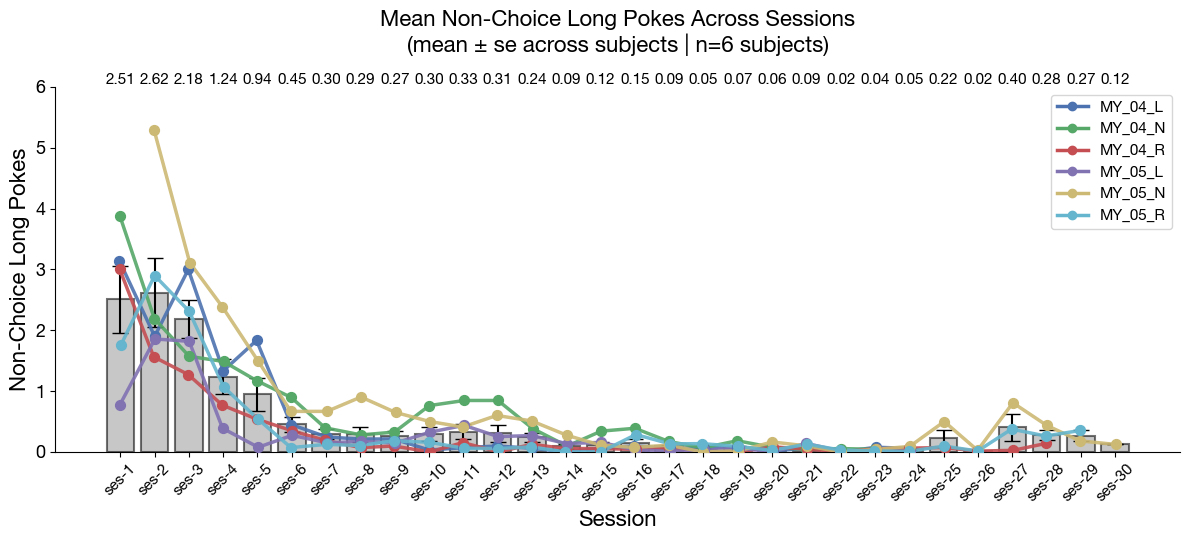

{'sessions': ['ses-1_date-20260111',
  'ses-2_date-20260111',
  'ses-3_date-20260112',
  'ses-4_date-20260112',
  'ses-5_date-20260113',
  'ses-6_date-20260113',
  'ses-7_date-20260114',
  'ses-8_date-20260114',
  'ses-9_date-20260115',
  'ses-10_date-20260115',
  'ses-11_date-20260116',
  'ses-12_date-20260116',
  'ses-13_date-20260117',
  'ses-14_date-20260117',
  'ses-15_date-20260118',
  'ses-16_date-20260118',
  'ses-17_date-20260119',
  'ses-18_date-20260119',
  'ses-19_date-20260120',
  'ses-20_date-20260120',
  'ses-21_date-20260121',
  'ses-22_date-20260121',
  'ses-23_date-20260122',
  'ses-24_date-20260122',
  'ses-25_date-20260123',
  'ses-26_date-20260123',
  'ses-27_date-20260124',
  'ses-28_date-20260124',
  'ses-29_date-20260125',
  'ses-30_date-20260125'],
 'per_session_mean': array([2.50741758, 2.61597222, 2.18099146, 1.23903134, 0.94443105,
        0.45122904, 0.29563733, 0.29109942, 0.26900474, 0.29611403,
        0.32949407, 0.30860114, 0.23855249, 0.09346264, 0.12

In [60]:
plot_num_pokes_across_mice(avg_num_pokes_across_subjects)

In [92]:
import re
import json
from typing import Dict, List, Tuple, Optional, Iterable
import numpy as np
import pandas as pd

ARMS9 = ["A1","A2","A3","B1","B2","B3","C1","C2","C3"]

_POKE_RE = re.compile(r"\b([ABC][123])_in\b")

def _collapse_consecutive_same(seq: Iterable[str]) -> List[str]:
    """Collapse consecutive duplicates: A1,A1,B2,B2,B2,C3 -> A1,B2,C3"""
    out = []
    prev = None
    for x in seq:
        if x is None:
            continue
        if x != prev:
            out.append(x)
            prev = x
    return out

def _coerce_trial_pokes_list(x) -> List[str]:
    """
    Try to coerce a 'num_long_pokes' entry into a list of well labels like ['C1','C2',...].
    Handles:
      - already a list of strings
      - a single string like 'C1' or 'C1,C2'
      - None/NaN
    """
    if x is None:
        return []
    if isinstance(x, float) and not np.isfinite(x):
        return []
    if isinstance(x, (list, tuple)):
        return [str(v) for v in x if v is not None]
    if isinstance(x, str):
        # allow "C1,C2,C3" or "['C1','C2']" or "C1"
        s = x.strip()
        # try JSON list
        if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
            try:
                arr = json.loads(s.replace("'", '"'))
                if isinstance(arr, list):
                    return [str(v) for v in arr]
            except Exception:
                pass
        # fallback: split on comma/space
        parts = re.split(r"[,\s]+", s)
        parts = [p for p in parts if p]
        return parts
    # last resort
    return [str(x)]

def get_pokes_before_choice_from_trials(
    session_trials: dict,
    *,
    long_pokes_key: str = "long_pokes",
    choice_key: Optional[str] = "chosen_tower",
    add_choice_bonus: int = 1,
    valid_arms: List[str] = ARMS9,
) -> Tuple[Dict[str, int], Dict[int, List[str]]]:
    """
    Count pokes from per-trial lists stored in session_trials[long_pokes_key].

    Rules:
      - Count "visits": consecutive pokes at same location are collapsed (A1,A1 -> one A1)
      - Add +add_choice_bonus to the choice poke (per trial)
        (choice poke is taken from choice_key if present; else uses last poke in the cleaned list)

    session_trials: one session's trial dict, e.g. subjects_trials[subj][session]

    Returns:
      counter: dict arm -> count
      pokes_across_trials: dict trial_number (1-indexed) -> cleaned poke sequence
    """
    counter = {k: 0 for k in valid_arms}
    pokes_across_trials: Dict[int, List[str]] = {}

    # Expect session_trials[long_pokes_key] is list-like: one entry per trial
    raw = session_trials.get(long_pokes_key, None)
    if raw is None:
        return counter, pokes_across_trials

    # Allow either list-of-trials, or dict trial->list
    if isinstance(raw, dict):
        trial_items = sorted(raw.items(), key=lambda kv: int(kv[0]))
        trials_iter = [(int(t), raw_list) for t, raw_list in trial_items]
        # We'll still map output trials sequentially, but preserve source trial index in ordering
        trials = [x[1] for x in trials_iter]
    else:
        trials = list(raw)

    # If choices are provided per trial (typical), use them
    choices = session_trials.get(choice_key, None) if choice_key else None
    if choices is not None and not isinstance(choices, (list, tuple, dict)):
        # sometimes it's a scalar or strange; ignore
        choices = None

    for i, trial_entry in enumerate(trials, start=1):
        pokes = _coerce_trial_pokes_list(trial_entry)
        # normalize to arm labels only
        pokes = [p for p in pokes if p in valid_arms]
        cleaned = _collapse_consecutive_same(pokes)

        # tally visits
        for p in cleaned:
            counter[p] += 1

        # determine choice poke for bonus
        choice_poke = None
        if choices is not None:
            if isinstance(choices, dict):
                # if choices keyed by trial number (1-indexed assumed)
                choice_poke = choices.get(i, None)
            else:
                # list-like parallel to trials
                if i - 1 < len(choices):
                    choice_poke = choices[i - 1]
        if choice_poke is None and cleaned:
            # fallback: assume last cleaned poke is the choice poke
            choice_poke = cleaned[-1]

        # add bonus
        if add_choice_bonus and choice_poke in valid_arms:
            counter[choice_poke] += int(add_choice_bonus)

        pokes_across_trials[i] = cleaned

    return counter, pokes_across_trials

import re
from typing import Dict, List, Tuple, Optional, Union
import pandas as pd

_POKE_IN_RE = re.compile(r"\b([ABC][123])_in\b")


def _collapse_consecutive_same(xs: List[str]) -> List[str]:
    out: List[str] = []
    prev = object()
    for x in xs:
        if x != prev:
            out.append(x)
            prev = x
    return out


def _drop_leading_choice_run(pokes: List[str], choice_arm: str) -> List[str]:
    i = 0
    n = len(pokes)
    while i < n and pokes[i] == choice_arm:
        i += 1
    return pokes[i:]


def _get_choice_from_list(choice_by_trial: Optional[List[Optional[str]]], trial_number: int) -> Optional[str]:
    """
    choice_by_trial is a list where index == trial number.
    So trial 1 is at choice_by_trial[1]. (choice_by_trial[0] can be None/dummy)
    """
    if not choice_by_trial:
        return None
    if trial_number < 0 or trial_number >= len(choice_by_trial):
        return None
    return choice_by_trial[trial_number]


def get_pokes_between_iti_and_wait_choice(
    df_or_dfs: Union[pd.DataFrame, List[pd.DataFrame]],
    *,
    iti_states: Tuple[str, ...] = ("ITI", "iti"),
    choice_wait_states: Tuple[str, ...] = ("wait_for_choice_poke", "wait_choice"),
    valid_arms: Optional[List[str]] = None,  # ["A1".. "C3"]
    collapse_consecutive: bool = True,
    # list where index == trial_number (recommended: put None at index 0)
    choice_by_trial: Optional[List[Optional[str]]] = None,
    # Optional: restrict to trials by print markers
    print_subtype: str = "print",
    print_variable_marker: Optional[str] = None,
) -> Tuple[Dict[str, int], Dict[int, List[str]]]:
    """
    For each ITI->wait_choice window:
      - collect *_in pokes (A1_in..C3_in)
      - if choice_by_trial provided: drop the leading run of choice-arm pokes, so
        counting starts only once the animal first leaves the choice arm
      - optionally collapse consecutive duplicates
      - tally counts per arm

    Returns:
      counter: dict arm->count
      pokes_by_trial: dict trial_number->list of counted arms (A1..C3)
    """
    if valid_arms is None:
        valid_arms = [f"{a}{i}" for a in "ABC" for i in "123"]

    # --- combine dfs if needed ---
    if isinstance(df_or_dfs, list):
        dfs = [d for d in df_or_dfs if isinstance(d, pd.DataFrame)]
        if not dfs:
            return {k: 0 for k in valid_arms}, {}
        df = pd.concat(dfs, ignore_index=True)
    else:
        df = df_or_dfs

    counter: Dict[str, int] = {k: 0 for k in valid_arms}
    pokes_by_trial: Dict[int, List[str]] = {}

    if not isinstance(df, pd.DataFrame) or "content" not in df.columns:
        return counter, pokes_by_trial

    content_all = df["content"].astype(str)

    # optional: slice by print_variable markers
    if print_variable_marker is not None and "subtype" in df.columns:
        pv_mask = (df["subtype"] == print_subtype) & content_all.str.contains(print_variable_marker, na=False)
        pv_idx = df.index[pv_mask].to_list()
        if not pv_idx:
            return counter, pokes_by_trial
        trial_slices: List[Tuple[int, int]] = []
        for i, s in enumerate(pv_idx):
            e = pv_idx[i + 1] if i + 1 < len(pv_idx) else df.index[-1]
            trial_slices.append((s, e))
    else:
        trial_slices = [(df.index[0], df.index[-1])]

    trial_number = 1

    for slice_start, slice_end in trial_slices:
        slc = df.loc[slice_start:slice_end]
        slc_content = slc["content"].astype(str)

        iti_idx = slc.index[slc_content.isin(iti_states)].to_list()
        if not iti_idx:
            continue

        for iti_i, iti_row_idx in enumerate(iti_idx):
            # find next stop state after this ITI within the slice
            stop_row_idx = None
            pos0 = slc.index.get_loc(iti_row_idx)
            forward_indices = slc.index[pos0 + 1 :]

            for ridx in forward_indices:
                if str(df.at[ridx, "content"]) in choice_wait_states:
                    stop_row_idx = ridx
                    break

            # build window (exclusive endpoints)
            if stop_row_idx is not None:
                window = df.loc[iti_row_idx:stop_row_idx].iloc[1:-1]  # after ITI, before stop
            else:
                next_iti = iti_idx[iti_i + 1] if iti_i + 1 < len(iti_idx) else slice_end
                window = df.loc[iti_row_idx:next_iti].iloc[1:]

            if window.empty:
                pokes_by_trial[trial_number] = []
                trial_number += 1
                continue

            win_content = window["content"].astype(str)

            pokes: List[str] = []
            for _, s in win_content.items():
                m = _POKE_IN_RE.search(s)
                if m:
                    arm = m.group(1)
                    if arm in valid_arms:
                        pokes.append(arm)

            # drop leading choice run (list-based choice_by_trial)
            choice_arm = _get_choice_from_list(choice_by_trial, trial_number)
            if choice_arm and pokes:
                pokes = _drop_leading_choice_run(pokes, choice_arm)

            if collapse_consecutive and pokes:
                pokes = _collapse_consecutive_same(pokes)

            for arm in pokes:
                counter[arm] += 1

            pokes_by_trial[trial_number] = pokes
            trial_number += 1

    return counter, pokes_by_trial


MY_05_L {'A1': 363, 'A2': 157, 'A3': 230, 'B1': 184, 'B2': 1466, 'B3': 187, 'C1': 170, 'C2': 141, 'C3': 282}
MY_04_L {'A1': 266, 'A2': 213, 'A3': 236, 'B1': 172, 'B2': 1033, 'B3': 175, 'C1': 76, 'C2': 127, 'C3': 206}
Error processing MY_05_N ses-1_date-20260111: 'choice'
MY_05_N {'A1': 253, 'A2': 165, 'A3': 202, 'B1': 133, 'B2': 1004, 'B3': 230, 'C1': 120, 'C2': 145, 'C3': 228}
MY_05_R {'A1': 331, 'A2': 241, 'A3': 237, 'B1': 211, 'B2': 931, 'B3': 211, 'C1': 155, 'C2': 166, 'C3': 314}
MY_04_R {'A1': 220, 'A2': 170, 'A3': 186, 'B1': 157, 'B2': 1224, 'B3': 150, 'C1': 109, 'C2': 120, 'C3': 226}
MY_04_N {'A1': 351, 'A2': 283, 'A3': 237, 'B1': 250, 'B2': 890, 'B3': 252, 'C1': 116, 'C2': 241, 'C3': 299}


/var/folders/g7/dhg2tq9173j2cwmlq6jvq28r0000gn/T/ipykernel_1255/3036677104.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap)
/var/folders/g7/dhg2tq9173j2cwmlq6jvq28r0000gn/T/ipykernel_1255/3036677104.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


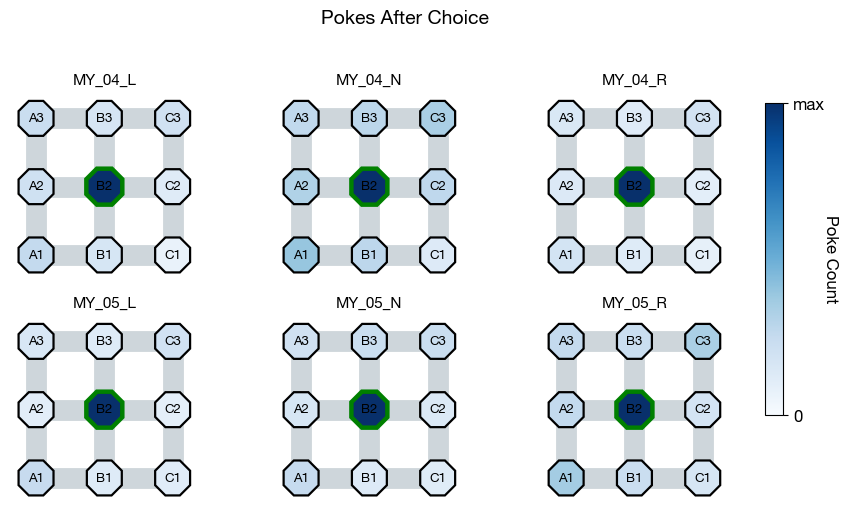

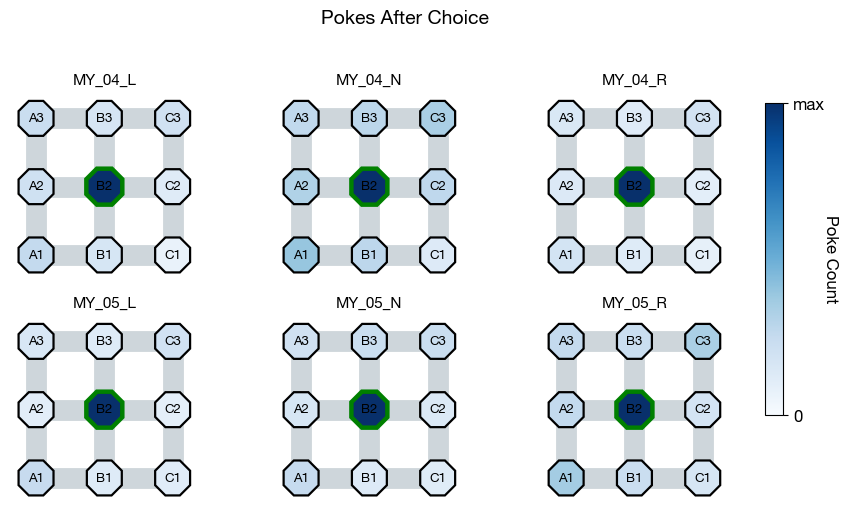

In [98]:
from collections import defaultdict

ARMS9 = ["A1","A2","A3","B1","B2","B3","C1","C2","C3"]

def sum_counters(counters):
    out = {a: 0 for a in ARMS9}
    for c in counters:
        if not c:
            continue
        for a in ARMS9:
            out[a] += int(c.get(a, 0))
    return out

# build: per_mouse_counter_sum[mouse] = summed counter across sessions
per_mouse_counter_sum = {}
for subject in subjects_trials.keys():
    subj_session_counters = []
    for session in subjects_trials[subject].keys():
        try:
            counter, pokes_by_trial = get_pokes_between_iti_and_wait_choice(
                subjects_data[subject][session]["df"],
                choice_by_trial=[None] + subjects_trials[subject][session]['choice'],
            )
            subj_session_counters.append(counter)
        except Exception as e:
            print(f"Error processing {subject} {session}: {e}")
    per_mouse_counter_sum[subject] = sum_counters(subj_session_counters)
    print(subject, per_mouse_counter_sum[subject])

plot_maze_heatmaps_per_mouse(
    per_mouse_counter_sum,
    title="Pokes After Choice",
    initiation_well="B2",                 # optional
    # choice_wells=["A1", "A3", "C3"],        # optional green outlines
    cmap="Blues",
    show_counts=False,
    save_path=None,                         # or Path(".../maze_heatmap")
)
        

MY_05_L {'A1': 617, 'A2': 24, 'A3': 455, 'B1': 41, 'B2': 85, 'B3': 37, 'C1': 21, 'C2': 26, 'C3': 415}
MY_04_L {'A1': 382, 'A2': 19, 'A3': 295, 'B1': 28, 'B2': 52, 'B3': 28, 'C1': 8, 'C2': 18, 'C3': 376}
MY_05_N {'A1': 327, 'A2': 32, 'A3': 393, 'B1': 43, 'B2': 99, 'B3': 51, 'C1': 26, 'C2': 30, 'C3': 312}
MY_05_R {'A1': 369, 'A2': 26, 'A3': 167, 'B1': 46, 'B2': 52, 'B3': 28, 'C1': 14, 'C2': 24, 'C3': 420}
MY_04_R {'A1': 542, 'A2': 25, 'A3': 346, 'B1': 20, 'B2': 51, 'B3': 16, 'C1': 9, 'C2': 22, 'C3': 362}
MY_04_N {'A1': 319, 'A2': 68, 'A3': 305, 'B1': 47, 'B2': 59, 'B3': 93, 'C1': 15, 'C2': 91, 'C3': 289}


/var/folders/g7/dhg2tq9173j2cwmlq6jvq28r0000gn/T/ipykernel_1255/3036677104.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap)
/var/folders/g7/dhg2tq9173j2cwmlq6jvq28r0000gn/T/ipykernel_1255/3036677104.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


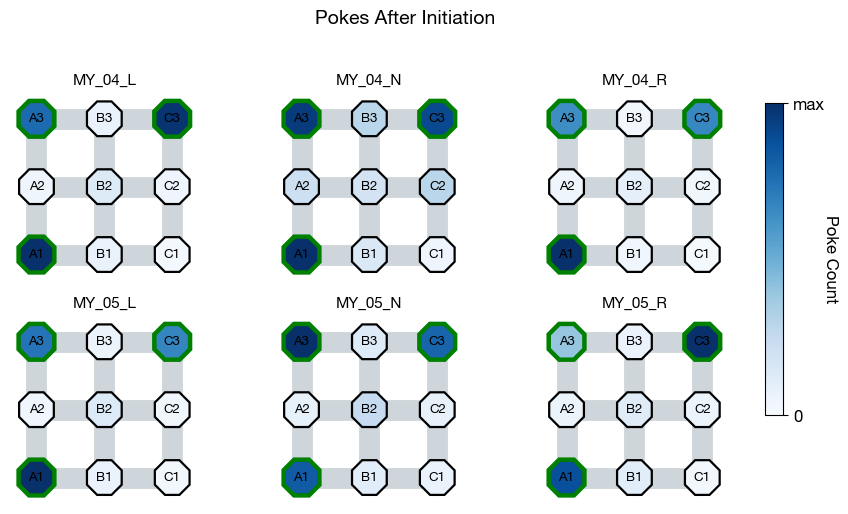

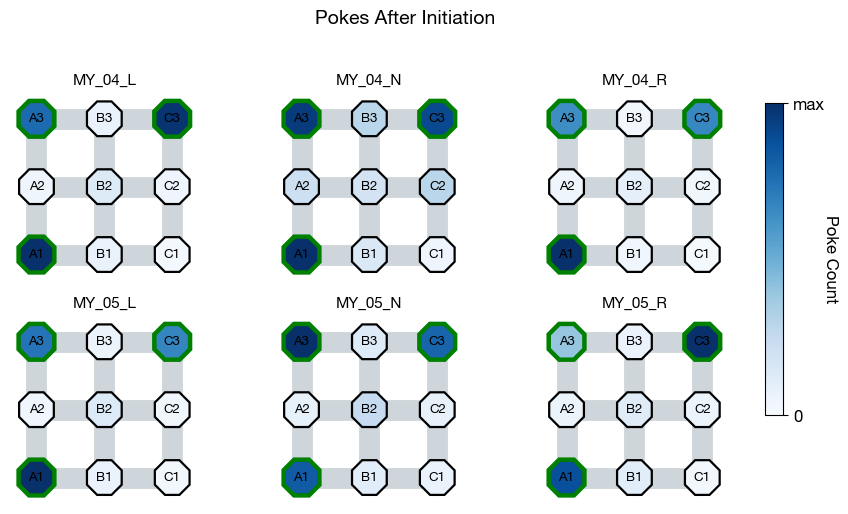

In [105]:
from collections import defaultdict

per_subject = {}

for subject, sessions in subjects_trials.items():
    subj_total = defaultdict(int)

    for session in sessions:
        try:
            counter, _ = get_pokes_before_choice_from_trials(
                subjects_trials[subject][session],
                long_pokes_key="long_pokes",
                choice_key="choice",
                add_choice_bonus=1,
            )
            for arm, n in counter.items():
                subj_total[arm] += int(n)

        except KeyError as e:
            print(f"Missing key {e} for {subject} {session}")
        except Exception as e:
            print(f"Error for {subject} {session}: {e}")

    per_subject[subject] = dict(subj_total)
    print(subject, dict(subj_total))

plot_maze_heatmaps_per_mouse(
    per_subject,
    title="Pokes After Initiation",
    # initiation_well="B2",                 # optional
    choice_wells=["A1", "A3", "C3"],        # optional green outlines
    cmap="Blues",
    show_counts=False,
    save_path=None,                         # or Path(".../maze_heatmap")
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.patches import RegularPolygon
import networkx as nx

ARMS9 = ["A1","A2","A3","B1","B2","B3","C1","C2","C3"]

def draw_maze_heatmap(
    counter,
    *,
    problem_number=None,
    initiation_well=None,
    choice_wells=None,
    cmap="Blues",
    vmin=None,
    vmax=None,
    show_counts=True,
    count_fmt="{:d}",
    edge_width=25,
    edge_color="#c9d2d7",
    node_radius=0.18,
    num_sides=8,
    outline_lw=2.0,
    highlight_initiation=True,
    highlight_choices=True,
    initiation_outline="#74abd3",
    choice_outline="#b1e3f7",
    highlight_lw=5.0,
    save_path=None,
):
    """
    counter: dict like {'A1': 10, ...} for the 9 wells.

    Colors each well by its count using a colormap, with an optional colorbar.
    Optionally outlines initiation_well / choice_wells to match your schematic style.
    """
    if choice_wells is None:
        choice_wells = []

    # Map well labels to grid positions (same as yours)
    well_map = {
        'A1': (2, 0), 'B1': (2, 1), 'C1': (2, 2),
        'A2': (1, 0), 'B2': (1, 1), 'C2': (1, 2),
        'A3': (0, 0), 'B3': (0, 1), 'C3': (0, 2)
    }

    # Grid graph and positions (same as yours)
    G = nx.grid_2d_graph(3, 3)
    pos = {(x, y): (y, 2 - x) for x, y in G.nodes()}

    scale = 0.65
    pos = {k: (scale * v[0], scale * v[1]) for k, v in pos.items()}

    # ---- normalize counts to colors ----
    vals = np.array([float(counter.get(a, 0)) for a in ARMS9], dtype=float)
    if vmin is None:
        vmin = float(np.nanmin(vals)) if vals.size else 0.0
    if vmax is None:
        vmax = float(np.nanmax(vals)) if vals.size else 1.0
    if vmax == vmin:
        vmax = vmin + 1.0  # avoid zero range

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap_obj = mpl.cm.get_cmap(cmap)

    fig, ax = plt.subplots(figsize=(8, 6))

    # ---- edges (bridges) ----
    for u, v in G.edges():
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        ax.plot([x1, x2], [y1, y2],
                linewidth=edge_width,
                color=edge_color,
                alpha=0.9,
                solid_capstyle='round',
                zorder=1)

    # ---- nodes (wells) ----
    for label, (r, c) in well_map.items():
        x, y = pos[(r, c)]
        value = float(counter.get(label, 0))
        facecolor = cmap_obj(norm(value))

        # base octagon
        octagon = RegularPolygon(
            (x, y),
            numVertices=num_sides,
            radius=node_radius,
            orientation=np.pi / 8,
            facecolor=facecolor,
            edgecolor='black',
            linewidth=outline_lw,
            zorder=2
        )
        ax.add_patch(octagon)

        # highlight outlines (optional)
        if highlight_initiation and initiation_well is not None and label == initiation_well:
            ax.add_patch(RegularPolygon(
                (x, y),
                numVertices=num_sides,
                radius=node_radius * 1.05,
                orientation=np.pi / 8,
                facecolor="none",
                edgecolor=initiation_outline,
                linewidth=highlight_lw,
                zorder=4
            ))

        if highlight_choices and label in (choice_wells or []):
            ax.add_patch(RegularPolygon(
                (x, y),
                numVertices=num_sides,
                radius=node_radius * 1.05,
                orientation=np.pi / 8,
                facecolor="none",
                edgecolor=choice_outline,
                linewidth=highlight_lw,
                zorder=4
            ))

        # label + optional count
        ax.text(x, y + 0.03, label,
                ha='center', va='center',
                fontsize=14, fontweight='bold', color='black',
                zorder=5)

        if show_counts:
            ax.text(x, y - 0.07, count_fmt.format(int(value)),
                    ha='center', va='center',
                    fontsize=12, color='black',
                    zorder=5)

    # ---- colorbar ----
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Poke count", rotation=90)

    # ---- optional title ----
    if problem_number is not None:
        ax.set_title(f"Bandit Problem {problem_number} — Poke Heatmap", fontsize=16, pad=16)

    # legend (outline meaning)
    handles = []
    if initiation_well is not None and highlight_initiation:
        handles.append(mpatches.Patch(facecolor="none", edgecolor=initiation_outline, linewidth=highlight_lw,
                                      label="Initiation tower (outline)"))
    if choice_wells and highlight_choices:
        handles.append(mpatches.Patch(facecolor="none", edgecolor=choice_outline, linewidth=highlight_lw,
                                      label="Choice towers (outline)"))
    if handles:
        ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1),
                  fontsize=12, frameon=False)

    ax.set_aspect('equal')
    ax.axis('off')
    plt.tight_layout()

    if save_path:
        fig.savefig(str(save_path), bbox_inches="tight", dpi=300)
    plt.show()
    plt.close(fig)

    return fig, ax


MY_05_L ses-1_date-20260111
MY_05_L ses-2_date-20260111
MY_05_L ses-3_date-20260112
MY_05_L ses-4_date-20260112
MY_05_L ses-5_date-20260113
MY_05_L ses-6_date-20260113
MY_05_L ses-7_date-20260114
MY_05_L ses-8_date-20260114
MY_05_L ses-9_date-20260115
MY_05_L ses-10_date-20260115
MY_05_L ses-11_date-20260116
MY_05_L ses-12_date-20260116
MY_05_L ses-13_date-20260117
MY_05_L ses-14_date-20260117
MY_05_L ses-15_date-20260118
MY_05_L ses-16_date-20260118
MY_05_L ses-17_date-20260119
MY_05_L ses-18_date-20260119
MY_05_L ses-19_date-20260120
MY_05_L ses-20_date-20260120
MY_05_L ses-21_date-20260121
MY_05_L ses-22_date-20260121
MY_05_L ses-23_date-20260122
MY_05_L ses-24_date-20260122
MY_04_L ses-1_date-20260111
MY_04_L ses-2_date-20260111
MY_04_L ses-3_date-20260112
MY_04_L ses-4_date-20260112
MY_04_L ses-5_date-20260113
MY_04_L ses-6_date-20260113
MY_04_L ses-7_date-20260114
MY_04_L ses-8_date-20260114
MY_04_L ses-9_date-20260115
MY_04_L ses-10_date-20260115
MY_04_L ses-11_date-20260116
MY_

/var/folders/g7/dhg2tq9173j2cwmlq6jvq28r0000gn/T/ipykernel_1255/3036677104.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap)
/var/folders/g7/dhg2tq9173j2cwmlq6jvq28r0000gn/T/ipykernel_1255/3036677104.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


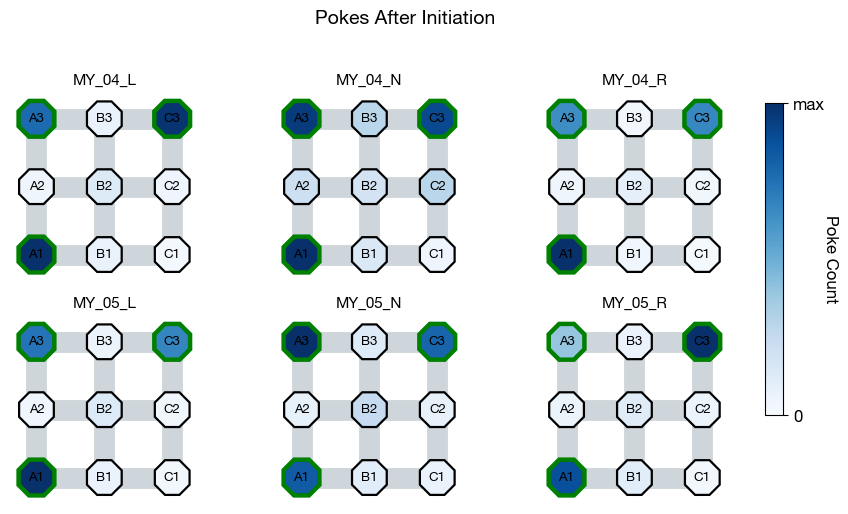

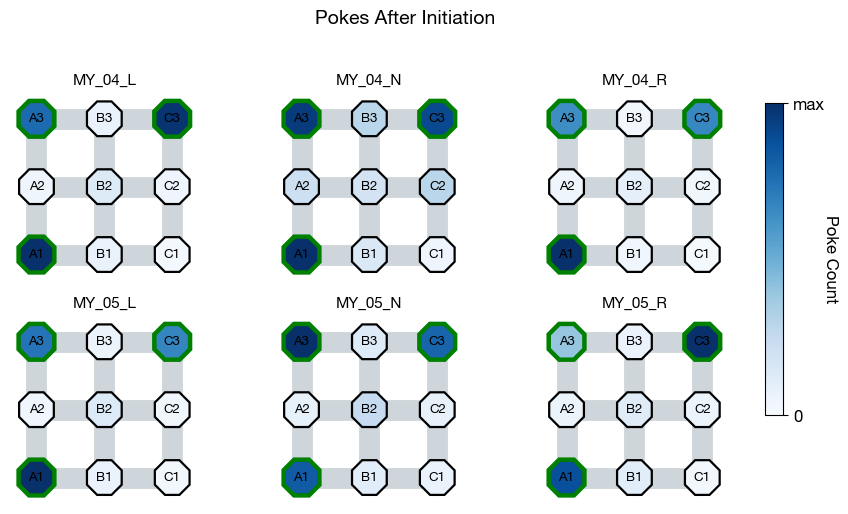

In [43]:
from collections import defaultdict

ARMS9 = ["A1","A2","A3","B1","B2","B3","C1","C2","C3"]

def add_counters(a: dict, b: dict):
    """Return a+b for two {'A1':int,...} dicts."""
    out = {k: int(a.get(k, 0)) for k in ARMS9}
    for k in ARMS9:
        out[k] += int(b.get(k, 0))
    return out

all_subjects = list(subjects_trials.keys())

# per_mouse_counter[mouse] -> {'A1': n, ...} summed across sessions
per_mouse_counter = {m: {k: 0 for k in ARMS9} for m in all_subjects}

# (optional) also keep per-session counters if you want later
per_mouse_session_counter = defaultdict(dict)

for subject in all_subjects:
    for session in subjects_trials[subject].keys():
        print(subject, session)
        try:
            counter, pokes_by_trial = get_pokes_before_choice_from_trials(
                subjects_trials[subject][session],
                long_pokes_key="long_pokes",
                choice_key="choice",   # or None if not present
                add_choice_bonus=1,
            )

            # store per-session (optional)
            per_mouse_session_counter[subject][session] = counter

            # accumulate into per-mouse total
            per_mouse_counter[subject] = add_counters(per_mouse_counter[subject], counter)

        except Exception as e:
            print(f"Missing long_pokes for {subject} {session}: {e}")

# Now plot: one maze per mouse
plot_maze_heatmaps_per_mouse(
    per_mouse_counter,
    title="Pokes After Initiation",
    # initiation_well="B3",                 # optional
    choice_wells=["A1", "A3", "C3"],        # optional green outlines
    cmap="Blues",
    show_counts=False,
    save_path=None,                         # or Path(".../maze_heatmap")
)


In [42]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import RegularPolygon
import networkx as nx

ARMS9 = ["A1","A2","A3","B1","B2","B3","C1","C2","C3"]

def plot_maze_heatmaps_per_mouse(
    per_mouse_counter: dict,
    *,
    title="Problem 1 — Pokes After Initiation",
    initiation_well=None,
    choice_wells=None,
    cmap="Blues",
    show_counts=False,
    count_fmt="{:d}",
    node_radius=0.18,
    num_sides=8,
    bridge_width=15,
    bridge_color="#c9d2d7",
    outline_lw=1.6,
    highlight_lw=3.2,
    highlight_color="green",
    save_path=None,
):
    """
    Per-mouse normalization (colors reflect fraction of that mouse's max),
    but with a single shared colorbar labeled '0 ... max (per mouse)'.

    Layout: 2 rows, ncols = ceil(n_mice/2)
    """
    if choice_wells is None:
        choice_wells = []

    mice = sorted(per_mouse_counter.keys())
    n = len(mice)
    if n == 0:
        raise ValueError("per_mouse_counter is empty.")

    # ---- maze geometry ----
    well_map = {
        'A1': (2, 0), 'B1': (2, 1), 'C1': (2, 2),
        'A2': (1, 0), 'B2': (1, 1), 'C2': (1, 2),
        'A3': (0, 0), 'B3': (0, 1), 'C3': (0, 2)
    }
    G = nx.grid_2d_graph(3, 3)
    pos = {(x, y): (y, 2 - x) for x, y in G.nodes()}
    scale = 0.65
    pos = {k: (scale * v[0], scale * v[1]) for k, v in pos.items()}

    # ---- layout: exactly 2 rows, ncols = ceil(n/2) ----
    nrows = 2
    ncols = int(math.ceil(n / 2))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3.0, nrows * 2.6))
    axes = np.atleast_1d(axes).ravel()

    cmap_obj = mpl.cm.get_cmap(cmap)

    # IMPORTANT: shared norm is 0..1 because each mouse is normalized to its own max
    norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

    def draw_one(ax, counter, mouse_name):
        counter = counter or {}

        # per-mouse max (avoid divide by zero)
        vals = np.array([float(counter.get(a, 0)) for a in ARMS9], dtype=float)
        mmax = float(np.nanmax(vals)) if vals.size else 0.0
        if not np.isfinite(mmax) or mmax <= 0:
            mmax = 1.0  # everything becomes 0

        # bridges
        for u, v in G.edges():
            x1, y1 = pos[u]
            x2, y2 = pos[v]
            ax.plot([x1, x2], [y1, y2],
                    linewidth=bridge_width,
                    color=bridge_color,
                    alpha=0.9,
                    solid_capstyle="round",
                    zorder=1)

        # wells
        for label, (r, c) in well_map.items():
            x, y = pos[(r, c)]
            value = float(counter.get(label, 0))

            # normalize per mouse: 0..1
            frac = np.clip(value / mmax, 0.0, 1.0)
            facecolor = cmap_obj(norm(frac))

            # base octagon
            ax.add_patch(RegularPolygon(
                (x, y),
                numVertices=num_sides,
                radius=node_radius,
                orientation=np.pi / 8,
                facecolor=facecolor,
                edgecolor="black",
                linewidth=outline_lw,
                zorder=2
            ))

            # highlight outlines
            if label in (choice_wells or []):
                ax.add_patch(RegularPolygon(
                    (x, y),
                    numVertices=num_sides,
                    radius=node_radius * 1.03,
                    orientation=np.pi / 8,
                    facecolor="none",
                    edgecolor=highlight_color,
                    linewidth=highlight_lw,
                    zorder=3
                ))

            if initiation_well is not None and label == initiation_well:
                ax.add_patch(RegularPolygon(
                    (x, y),
                    numVertices=num_sides,
                    radius=node_radius * 1.03,
                    orientation=np.pi / 8,
                    facecolor="none",
                    edgecolor=highlight_color,
                    linewidth=highlight_lw,
                    zorder=3
                ))

            # label inside
            ax.text(x, y, label, ha="center", va="center",
                    fontsize=9.5, fontweight="bold", color="black", zorder=4)

            if show_counts:
                ax.text(x, y - 0.12, count_fmt.format(int(value)),
                        ha="center", va="center", fontsize=8.5, color="black", zorder=4)

        # title: mouse name (optionally include max)
        ax.set_title(f"{mouse_name}", fontsize=11, pad=6)
        ax.set_aspect("equal")
        ax.axis("off")

    # draw each mouse
    for i, m in enumerate(mice):
        draw_one(axes[i], per_mouse_counter[m], m)

    # hide unused axes
    for j in range(n, len(axes)):
        axes[j].axis("off")

    fig.suptitle(title, fontsize=14, y=0.98)

    # ---- ONE shared colorbar (0..1), labeled 0..max (per mouse) ----
    # ---- ONE shared colorbar (outside, no overlap) ----
    # leave room on the right
    fig.subplots_adjust(right=0.88)

    # add a dedicated axis for the colorbar
    cax = fig.add_axes([0.90, 0.20, 0.02, 0.60])  # [left, bottom, width, height]

    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label(
        "Poke Count",
        rotation=270,
        va="center"
    )

    # match your “0 … max” aesthetic
    cbar.set_ticks([0.0, 1.0])
    cbar.set_ticklabels(["0", "max"])

    # match your “0 … max” look
    cbar.set_ticks([0.0, 1.0])
    cbar.set_ticklabels(["0", "max"])

    plt.tight_layout(rect=[0, 0, 0.92, 0.95])

    if save_path:
        fig.savefig(str(save_path) + ".png", dpi=300, bbox_inches="tight")
        fig.savefig(str(save_path) + ".pdf", bbox_inches="tight")
    else:
        plt.show()

    plt.close(fig)
    return fig

In [23]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import RegularPolygon
import networkx as nx

ARMS9 = ["A1","A2","A3","B1","B2","B3","C1","C2","C3"]

# ---------- shared maze geometry ----------
WELL_MAP = {
    'A1': (2, 0), 'B1': (2, 1), 'C1': (2, 2),
    'A2': (1, 0), 'B2': (1, 1), 'C2': (1, 2),
    'A3': (0, 0), 'B3': (0, 1), 'C3': (0, 2)
}

def _maze_graph_positions(scale=0.65):
    G = nx.grid_2d_graph(3, 3)
    pos = {(x, y): (y, 2 - x) for x, y in G.nodes()}   # flip y so row 1 is top
    pos = {k: (scale * v[0], scale * v[1]) for k, v in pos.items()}
    return G, pos


# ---------- 1) draw ONE mouse heatmap onto an axis ----------
def draw_maze_heatmap_on_ax(
    ax,
    counter,
    *,
    title=None,
    initiation_well=None,
    choice_wells=None,
    cmap="Blues",
    norm=None,                 # pass a shared Normalize for consistent scaling across mice
    vmin=None,
    vmax=None,
    show_counts=True,
    count_fmt="{:d}",
    edge_width=25,
    edge_color="#c9d2d7",
    node_radius=0.18,
    num_sides=8,
    outline_lw=2.0,
    highlight_initiation=True,
    highlight_choices=True,
    initiation_outline="#74abd3",
    choice_outline="#b1e3f7",
    highlight_lw=5.0,
):
    if choice_wells is None:
        choice_wells = []

    # choose norm
    vals = np.array([float(counter.get(a, 0)) for a in ARMS9], dtype=float)
    if norm is None:
        if vmin is None: vmin = float(np.nanmin(vals)) if vals.size else 0.0
        if vmax is None: vmax = float(np.nanmax(vals)) if vals.size else 1.0
        if vmax == vmin: vmax = vmin + 1.0
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    cmap_obj = mpl.cm.get_cmap(cmap)

    G, pos = _maze_graph_positions(scale=0.65)

    # edges
    for u, v in G.edges():
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        ax.plot([x1, x2], [y1, y2],
                linewidth=edge_width,
                color=edge_color,
                alpha=0.9,
                solid_capstyle="round",
                zorder=1)

    # wells
    for label, (r, c) in WELL_MAP.items():
        x, y = pos[(r, c)]
        value = float(counter.get(label, 0))
        facecolor = cmap_obj(norm(value))

        # base octagon
        ax.add_patch(RegularPolygon(
            (x, y),
            numVertices=num_sides,
            radius=node_radius,
            orientation=np.pi / 8,
            facecolor=facecolor,
            edgecolor="black",
            linewidth=outline_lw,
            zorder=2
        ))

        # outlines
        if highlight_initiation and initiation_well is not None and label == initiation_well:
            ax.add_patch(RegularPolygon(
                (x, y),
                numVertices=num_sides,
                radius=node_radius * 1.05,
                orientation=np.pi / 8,
                facecolor="none",
                edgecolor=initiation_outline,
                linewidth=highlight_lw,
                zorder=4
            ))

        if highlight_choices and label in (choice_wells or []):
            ax.add_patch(RegularPolygon(
                (x, y),
                numVertices=num_sides,
                radius=node_radius * 1.05,
                orientation=np.pi / 8,
                facecolor="none",
                edgecolor=choice_outline,
                linewidth=highlight_lw,
                zorder=4
            ))

        # label + count
        ax.text(x, y + 0.03, label,
                ha="center", va="center",
                fontsize=14, fontweight="bold",
                zorder=5)

        if show_counts:
            ax.text(x, y - 0.075, count_fmt.format(int(value)),
                    ha="center", va="center",
                    fontsize=12,
                    zorder=5)

    if title is not None:
        ax.set_title(title, fontsize=14, pad=6)

    ax.set_aspect("equal")
    ax.axis("off")

    return norm  # so caller can reuse

In [24]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_maze_heatmaps_per_mouse_normalized(
    per_mouse_counter,
    *,
    initiation_well=None,
    choice_wells=None,
    cmap="Blues",
    show_counts=True,
    edge_width=25,
    node_radius=0.18,
    figsize_per_ax=(3.2, 3.0),
    add_colorbar_per_mouse=True,
    colorbar_label="Poke Count",
    save_path=None,
):
    """
    2 rows, ncols = ceil(n_mice/2)
    Per-mouse normalization: each mouse uses its own vmin/vmax based on its counter.
    """
    mice = sorted(per_mouse_counter.keys())
    n = len(mice)
    if n == 0:
        raise ValueError("per_mouse_counter is empty.")

    nrows = 2
    ncols = math.ceil(n / 2)

    fig_w = ncols * figsize_per_ax[0]
    fig_h = nrows * figsize_per_ax[1]
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h))
    axes = np.array(axes).reshape(nrows, ncols)

    cmap_obj = mpl.cm.get_cmap(cmap)

    for i, m in enumerate(mice):
        r = i // ncols
        c = i % ncols
        ax = axes[r, c]

        counter = per_mouse_counter[m]
        vals = np.array([float(counter.get(a, 0)) for a in ARMS9], dtype=float)

        vmin = float(np.nanmin(vals)) if vals.size else 0.0
        vmax = float(np.nanmax(vals)) if vals.size else 1.0
        if vmax == vmin:
            vmax = vmin + 1.0
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

        # draw the maze on this axis (uses THIS mouse's norm)
        draw_maze_heatmap_on_ax(
            ax,
            counter,
            title=m,
            initiation_well=initiation_well,
            choice_wells=choice_wells,
            cmap=cmap,
            norm=norm,
            show_counts=show_counts,
            edge_width=edge_width,
            node_radius=node_radius,
        )

        # per-axis colorbar (0..max for THIS mouse)
        if add_colorbar_per_mouse:
            sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, fraction=0.04, pad=0.02)
            cbar.set_label(colorbar_label, rotation=90)

            # label endpoints as 0 / max (your example style)
            cbar.set_ticks([norm.vmin, norm.vmax])
            cbar.set_ticklabels(["0", "max"])

    # turn off empty axes if n is odd
    for j in range(n, nrows * ncols):
        r = j // ncols
        c = j % ncols
        axes[r, c].axis("off")

    plt.tight_layout()

    if save_path:
        fig.savefig(str(save_path) + ".png", dpi=300, bbox_inches="tight")
        fig.savefig(str(save_path) + ".pdf", bbox_inches="tight")
    else:
        plt.show()

    plt.close(fig)
    return fig
